In [82]:
#pip install language-tool-python
#pip install pyaspeller

In [76]:
import pandas as pd
import numpy as np
from string import punctuation
import time
import re
from collections import Counter
import matplotlib.pyplot as plt 

In [77]:
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [79]:
import spacy
import ru_core_news_sm 

In [80]:
import gensim
from gensim.models import CoherenceModel 
from gensim.models import LdaModel
import gensim.corpora as corpora 

In [81]:
from pyaspeller import YandexSpeller

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/svetlanaponamarenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
stopwords = STOP_WORDS

In [20]:
len(stopwords)

768

In [13]:
#prevent SettingWithCopyWarning message from appearing
pd.options.mode.chained_assignment = None

## Загрузка и предварительный анализ отзывов

In [21]:
df = pd.read_csv('/Users/svetlanaponamarenko/Desktop/Python/сбор/reviews_sbor.csv')

In [22]:
df['review'][0]

'Ничего хорошего сказать не могу. Доставку задержали на неделю. Одно место было в пути вскрыто,скотч разрезан.'

In [23]:
df.shape

(101108, 2)

In [24]:
df['company'].value_counts()

company
ДЛ     56779
КИТ    23625
ПЭК    20704
Name: count, dtype: int64

In [25]:
df['length'] = df['review'].apply(lambda x: len(x.split()) if x.count(' ')>0 else 1)

In [26]:
df.describe()

,length
count,101108.000000
mean,28.702803
std,42.164050
min,1.000000
25%,7.000000
50%,15.000000
75%,33.000000
max,1195.000000


In [27]:
df.head()

,company,review,length
0,ПЭК,Ничего хорошего сказать не могу. Доставку заде...,16
1,ПЭК,"Персонал хороший, все отлично 👍",5
2,ПЭК,"Груз доставляют в сроки, когда посчитают возмо...",112
3,ПЭК,Часто пользуюсь услугами перевозки негабаритны...,35
4,ПЭК,"Груз лежит без движения уже 10 дней , когда он...",72


## Преобработка текста отзывов

In [44]:
# удаление из текста именнованных сущностей

nlp = ru_core_news_sm.load()

def del_ent_types(text):
    doc = nlp(text)
    to_del = []
    for ent in doc.ents:
        to_del.append(ent.text)
    for el in to_del:
        text = text.replace(el, '', text.count(el))
    return text

/opt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [45]:
# удаление из текста названий компаний

def del_company_names(text):
    word_del = ['деловые линии', 'пэк ', ' пэк', 'тк ', ' тк', ' кит', 'кит ', ' сдэк', 'сдэк ', 'авито', 'яндекс',\
               'компания', 'транспортная']
    text = text.lower()
    for el in word_del:
        if el in text:
            text = text.replace(el, ' ').strip()
    return text

In [46]:
# удаление из текста пунктуации, стоп-слов и небуквенных символов

punctuations = string.punctuation
stopwords = STOP_WORDS
print(len(stopwords))

def cleaner(text):
    text = ''.join(i for i in text if i not in punctuations)
    text = [ word.lower().strip().replace('ё', 'е') for word in text.split() ]
    text = [ word for word in text if word not in stopwords]
    text = " ".join([i for i in text if i.isalpha()])
    return text

768


In [47]:
stopwords.add('не')
stopwords.add('надо')
stopwords.add('ни')

In [48]:
# токенизация и лемматизация текста

def spacy_processor(text):
    mytokens = nlp(text)
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    mytokens = [ word for word in mytokens ]
    mytokens = " ".join([i for i in mytokens if i.isalpha()])
    return mytokens

In [33]:
%%time
df['text_clear'] = df['review'].apply(del_ent_types)

CPU times: user 21min 19s, sys: 29.7 s, total: 21min 49s
Wall time: 22min 15s


In [35]:
%%time
df['text_clear'] = df['text_clear'].apply(del_company_names)

CPU times: user 499 ms, sys: 28.9 ms, total: 528 ms
Wall time: 641 ms


In [36]:
%%time
df['text_clear'] = df['text_clear'].apply(cleaner)

CPU times: user 3.41 s, sys: 42.7 ms, total: 3.45 s
Wall time: 3.64 s


In [37]:
df.head()

,company,review,length,text_clear
0,ПЭК,Ничего хорошего сказать не могу. Доставку заде...,16,хорошего сказать доставку задержали неделю мес...
1,ПЭК,"Персонал хороший, все отлично 👍",5,персонал хороший отлично
2,ПЭК,"Груз доставляют в сроки, когда посчитают возмо...",112,груз доставляют сроки посчитают возможным срок...
3,ПЭК,Часто пользуюсь услугами перевозки негабаритны...,35,пользуюсь услугами перевозки негабаритных груз...
4,ПЭК,"Груз лежит без движения уже 10 дней , когда он...",72,груз лежит движения дней приедет знает постоян...


### Мешок слов

In [38]:
words = Counter()

In [39]:
# создаем "мешок слов", встречающихся в отзывах

for txt in df['text_clear']:
    words.update(txt.split())

In [40]:
words.most_common(10)

[('груз', 36218),
 ('быстро', 18344),
 ('груза', 13337),
 ('раз', 9311),
 ('доставки', 8027),
 ('доставка', 7504),
 ('компании', 7415),
 ('доставку', 7313),
 ('время', 6643),
 ('день', 5990)]

In [41]:
len(words)

98999

In [42]:
word_count = dict()

In [43]:
for i, word in enumerate(words.most_common(len(words))):
    word_count[word[0]] = word[1]

In [44]:
sum_of_words = sum(list(words.values()))

In [45]:
# словарь вероятности слова в отзывах

p = dict()
for i, word in enumerate(words.most_common(len(words))):
    p[word[0]] = word[1] / sum_of_words

In [46]:
# загружаем словарь русского языка для дальнейшей проверки корректности написания отзывов

with open('/Users/svetlanaponamarenko/Desktop/work/russian.txt', 'r') as file:
    lines = list(line.strip().lower() for line in file)

In [47]:
lines[130000:130005]

['водворёнными', 'водворенных', 'водворённых', 'водворено', 'водворёно']

In [48]:
len(lines)

1532629

In [51]:
# дополняем словарь

lines.append('инн')
lines.append('ндс')
lines.append('смс')
lines.append('клиентоориентированность')

In [52]:
lines_tuple = tuple(lines)

In [53]:
# проверяем слова из отзыва на предмет присутствия их в словаре
# отдельно сохраняем слова, которых нет в словаре, чтобы в дальнейшем отправить их на корректировку

def list_of_unknown_words(words):
    unknown = []
    for i, word in enumerate(words.most_common(len(words))):
        if word[0] not in lines_tuple:
            unknown.append(word[0])
    return unknown

In [54]:
def only_russian_letters(text):
    pattern = re.compile("[а-яА-ЯёЁ]+")
    return bool(pattern.fullmatch(text))

In [55]:
# первый этап корректировки ошибок и опечаток в отзывах

def error_correct_pyspeller(list):
    speller = YandexSpeller()
    correct_dict = dict()
    dont_correct = []
    for word in list:
        if only_russian_letters(word):
            fixed_word = speller.spelled(word)
            if len(fixed_word.split()) > 1:
                correct_dict[word] = fixed_word
            elif fixed_word in lines_tuple:
                correct_dict[word] = fixed_word
            else:
                dont_correct.append(word)
                
    return correct_dict, dont_correct

In [56]:
# второй этап корректировки ошибок и опечаток

def splits(word):
    "Возвращает список всех возможных разбиений слова на пару (a, b)."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

def edits1(word):
    "Возвращает список всех строк на расстоянии 1 от word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in ru_al if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in ru_al]
    return set(deletes + transposes + replaces + inserts)

ru_al = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'

def replacement_unknown_words(list):
    res_dict = dict()
    for word in list:
        if only_russian_letters(word):
            temp_dict = dict()
            for el in edits1(word):
                if el in lines_tuple and p.get(el):
                    temp_dict[el] = p.get(el)
            if len(temp_dict)>0:
                max_key = max(temp_dict, key = lambda k: temp_dict[k])
                res_dict[word] = max_key
    return res_dict

In [57]:
# замена скорректированных слов

def correct_text(text):
    for word in text.split():
        for key in list(correct_dict.keys()):
            if key == word: 
                text = text.replace(word, correct_dict[key])
    return text

In [58]:
%%time
unknown = list_of_unknown_words(words)

CPU times: user 22min 10s, sys: 11.2 s, total: 22min 21s
Wall time: 23min 56s


In [63]:
len(unknown)

39936

In [64]:
unknown[:15]

['тд',
 'вообщем',
 'какието',
 'квест',
 'почемуто',
 'ps',
 'паллет',
 'палет',
 'палетный',
 'небыло',
 'gtd',
 'логистическая',
 'мск',
 'тп',
 'наконецто']

In [65]:
%%time
correct_dict, dont_correct = error_correct_pyspeller(unknown)

CPU times: user 15min 25s, sys: 59.7 s, total: 16min 24s
Wall time: 2h 6min 44s


In [66]:
for i, (key, value) in enumerate(correct_dict.items()):
    if i < 10:
        print(f"{key}: {value}")

вообщем: в общем
какието: какие то
почемуто: почему то
небыло: не было
наконецто: наконец то
притензию: претензию
вобщем: в общем
типо: типа
коллцентр: колл центр
притензий: претензий


In [67]:
dont_correct[:10]

['тд',
 'квест',
 'паллет',
 'палет',
 'палетный',
 'логистическая',
 'мск',
 'тп',
 'пофиг',
 'колл']

In [68]:
len(dont_correct)

6617

In [769]:
%%time
correct_dict_2 = replacement_unknown_words(dont_correct)

CPU times: user 8h 52min 18s, sys: 44.7 s, total: 8h 53min 2s
Wall time: 8h 56min 43s


In [ ]:
res_dict.update(correct_dict_2)

In [69]:
%%time
df['text_correct'] = df['text_clear'].apply(correct_text)

CPU times: user 47min 24s, sys: 18 s, total: 47min 42s
Wall time: 48min 36s


In [79]:
df.head()

,company,review,length,text_clear,text_correct,res_text
0,ПЭК,Ничего хорошего сказать не могу. Доставку заде...,16,хорошего сказать доставку задержали неделю мес...,хорошего сказать доставку задержали неделю мес...,хорошего сказать доставку задержали неделю мес...
1,ПЭК,"Персонал хороший, все отлично 👍",5,персонал хороший отлично,персонал хороший отлично,персонал хороший отлично
2,ПЭК,"Груз доставляют в сроки, когда посчитают возмо...",112,груз доставляют сроки посчитают возможным срок...,груз доставляют сроки посчитают возможным срок...,груз доставляют сроки посчитают возможным срок...
3,ПЭК,Часто пользуюсь услугами перевозки негабаритны...,35,пользуюсь услугами перевозки негабаритных груз...,пользуюсь услугами перевозки негабаритных груз...,пользуюсь услугами перевозки негабаритных груз...
4,ПЭК,"Груз лежит без движения уже 10 дней , когда он...",72,груз лежит движения дней приедет знает постоян...,груз лежит движения дней приедет знает постоян...,груз лежит движения дней приедет знает постоян...


In [74]:
df['res_text'] = df['text_correct'].apply(del_ent_types)

In [78]:
%%time
df['res_text'] = df['text_correct'].apply(cleaner)

CPU times: user 2.47 s, sys: 98.1 ms, total: 2.57 s
Wall time: 2.76 s


In [80]:
%%time
df['res_lemm'] = df['res_text'].apply(spacy_processor)

CPU times: user 13min 31s, sys: 7.83 s, total: 13min 39s
Wall time: 13min 46s


In [81]:
df['res_length'] = df['res_lemm'].apply(lambda x: len(list(str(x).split())))

In [82]:
%%time
df['res_lemm'] = df['res_lemm'].apply(lambda x: x.replace('транспортный', '').replace('компания', '').strip())

CPU times: user 58 ms, sys: 4.92 ms, total: 62.9 ms
Wall time: 75.5 ms


In [83]:
df.describe()

,length,res_length
count,101108.000000,101108.000000
mean,28.702803,15.380563
std,42.164050,20.917598
min,1.000000,0.000000
25%,7.000000,4.000000
50%,15.000000,9.000000
75%,33.000000,18.000000
max,1195.000000,557.000000


In [84]:
df.head()

,company,review,length,text_clear,text_correct,res_text,res_lemm,res_length
0,ПЭК,Ничего хорошего сказать не могу. Доставку заде...,16,хорошего сказать доставку задержали неделю мес...,хорошего сказать доставку задержали неделю мес...,хорошего сказать доставку задержали неделю мес...,хороший сказать доставка задержать неделя мест...,9
1,ПЭК,"Персонал хороший, все отлично 👍",5,персонал хороший отлично,персонал хороший отлично,персонал хороший отлично,персонал хороший отлично,3
2,ПЭК,"Груз доставляют в сроки, когда посчитают возмо...",112,груз доставляют сроки посчитают возможным срок...,груз доставляют сроки посчитают возможным срок...,груз доставляют сроки посчитают возможным срок...,груз доставлять срок посчитают возможный срок ...,64
3,ПЭК,Часто пользуюсь услугами перевозки негабаритны...,35,пользуюсь услугами перевозки негабаритных груз...,пользуюсь услугами перевозки негабаритных груз...,пользуюсь услугами перевозки негабаритных груз...,пользоваться услуга перевозка негабаритных гру...,22
4,ПЭК,"Груз лежит без движения уже 10 дней , когда он...",72,груз лежит движения дней приедет знает постоян...,груз лежит движения дней приедет знает постоян...,груз лежит движения дней приедет знает постоян...,груз лежать движение день приехать знать посто...,29


In [85]:
df.to_csv('reviews_post.csv', index=False)

In [2]:
df = pd.read_csv('reviews_post.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101108 entries, 0 to 101107
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   company       101108 non-null  object
 1   review        101108 non-null  object
 2   length        101108 non-null  int64 
 3   text_clear    100499 non-null  object
 4   text_correct  100499 non-null  object
 5   res_text      100491 non-null  object
 6   res_lemm      100483 non-null  object
 7   res_length    101108 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.2+ MB


In [4]:
df['res_lemm'] = df['res_lemm'].astype(str)

## Модель латентного размещения Дирихле (LDA) 

### Вариант 1

In [26]:
res_dict_words = Counter()
for txt in df['res_lemm']:
    res_dict_words.update(txt.split())

In [27]:
res_dict_words.most_common(10)

[('груз', 55907),
 ('доставка', 26028),
 ('быстро', 19202),
 ('день', 15791),
 ('работать', 13273),
 ('раз', 12494),
 ('очередь', 11757),
 ('склад', 10542),
 ('хороший', 10216),
 ('время', 9299)]

In [28]:
filtered_reviews = []
for review in df['res_lemm']:
    words = review.split()
    filtered_words = [word for word in words if 0.05 <= res_dict_words[word] / len(df['res_lemm']) <= 0.50]
    filtered_reviews.append(' '.join(filtered_words))

In [103]:
len(df['res_lemm'])

101108

In [104]:
filtered_reviews[:10]

['хороший сказать доставка место',
 'персонал хороший',
 'срок срок срок доставка раз день срок день срок доставка проблема доставить срок клиент доставка клиент',
 'пользоваться услуга склад персонал склад',
 'день приехать человек доставка срок приехать',
 'быстро проблема пользоваться услуга раз',
 'быстро очередь склад',
 'срок доставка услуга',
 'проблема ждать',
 'отправить приехать день день раз']

In [105]:
len(res_dict_words)

39881

In [135]:
#res_dict_words.most_common(1000)

In [142]:
%%time
vectorizer = TfidfVectorizer(max_features=250)
tfidf_matrix = vectorizer.fit_transform(filtered_reviews)

CPU times: user 412 ms, sys: 17.6 ms, total: 430 ms
Wall time: 515 ms


In [143]:
lda = LatentDirichletAllocation(n_components=5, learning_decay=0.7, learning_method='online', random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=42)

In [144]:
topics = lda.components_

In [145]:
feature_names = vectorizer.get_feature_names_out()

In [146]:
for topic_idx, topic in enumerate(topics):
    print(f"Тема #{topic_idx + 1}:")
    top_words = topic.argsort()[:-6:-1]  # Выбираем топ-5 слов
    for word_idx in top_words:
        print(f"{feature_names[word_idx]} ({topic[word_idx]:.3f})")
    print()

Тема #1:
хороший (5834.564)
раз (4754.971)
пользоваться (3302.544)
услуга (3004.084)
отправлять (2875.213)

Тема #2:
удобный (4181.110)
цена (3943.595)
клиент (2845.104)
терминал (2561.676)
проблема (2424.279)

Тема #3:
быстро (10560.915)
персонал (4116.217)
обслуживание (3340.426)
быстрый (3204.003)
рекомендовать (1619.440)

Тема #4:
доставка (6847.248)
работать (6201.766)
день (5542.560)
время (3740.421)
отправить (3213.181)

Тема #5:
очередь (5620.686)
склад (4429.060)
товар (3523.267)
сотрудник (3299.492)
место (3086.373)



In [147]:
get_coherence_mean_(lda, filtered_reviews)

0.4811409855675377

In [114]:
# https://stackoverflow.com/questions/60613532/how-do-i-calculate-the-coherence-score-of-an-sklearn-lda-model
def get_coherence_mean_(model, texts, n_top_words=20): #получение средней оценки коберентностости
    # кол-во тем
    topics = model.components_
    # получение токенов
    texts = [[word for word in doc.split()] for doc in texts]
    # создание словаря с использованием gensim
    dictionary = corpora.Dictionary(texts)

    corpus = [dictionary.doc2bow(text) for text in texts]
    
    feature_names = [dictionary[i] for i in range(len(dictionary))]

    top_words = []
    for topic in topics: 
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    
    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [116]:
def compute_coherence_values(vec_train_text, test_text, min_topic=2, max_topic=40, step=5):
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(min_topic, max_topic, step):
        model = LatentDirichletAllocation(max_iter=10, n_components=num_topics, learning_method='online',
                                          random_state=42, n_jobs=-1)
        model.fit(vec_train_text)
        
        model_list.append(model)
        coherence_values.append(get_coherence_mean_(model, test_text))
    
    return model_list, coherence_values

In [148]:
%%time
min_topic = 3
max_topic = 10
step = 1
model_list, coherence_values = compute_coherence_values(vec_train_text=tfidf_matrix, test_text=filtered_reviews, 
                                                        min_topic=min_topic, max_topic=max_topic,
                                                        step=step)

CPU times: user 4min 25s, sys: 22.5 s, total: 4min 48s
Wall time: 9min 21s


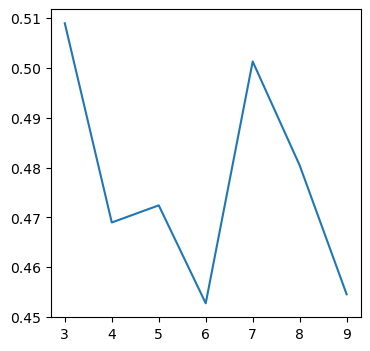

In [153]:
x = range(min_topic, max_topic, step)

plt.figure(figsize=(4,4))

plt.plot(x, coherence_values)
plt.show()

In [150]:
for n_topics, coherence in zip(x, coherence_values):
    print(f'{n_topics=}, {round(coherence,4)=}')

n_topics=3, round(coherence,4)=0.509
n_topics=4, round(coherence,4)=0.469
n_topics=5, round(coherence,4)=0.4724
n_topics=6, round(coherence,4)=0.4528
n_topics=7, round(coherence,4)=0.5013
n_topics=8, round(coherence,4)=0.4805
n_topics=9, round(coherence,4)=0.4546


In [154]:
lda = LatentDirichletAllocation(n_components=7, learning_decay=0.7, learning_method='online', random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(learning_method='online', n_components=7,
                          random_state=42)

In [155]:
topics = lda.components_
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(topics):
    print(f"Тема #{topic_idx + 1}:")
    top_words = topic.argsort()[:-6:-1]  # Выбираем топ-5 слов
    for word_idx in top_words:
        print(f"{feature_names[word_idx]} ({topic[word_idx]:.3f})")
    print()

Тема #1:
раз (3836.688)
пользоваться (3302.492)
услуга (3004.032)
время (2800.577)
прийти (1568.060)

Тема #2:
отправлять (2875.164)
клиент (2845.054)
документ (2499.481)
проблема (2424.229)
получить (2015.302)

Тема #3:
работать (5213.255)
склад (3355.426)
работа (3004.634)
персонал (2936.355)
товар (2922.791)

Тема #4:
посылка (3179.240)
сотрудник (2863.813)
человек (2481.883)
приехать (2395.219)
сказать (2298.096)

Тема #5:
цена (3943.544)
срок (3577.964)
очередь (3405.606)
день (3213.715)
отправить (2349.898)

Тема #6:
доставка (5643.106)
быстрый (3203.952)
оператор (2856.921)
доставить (2618.461)
терминал (2561.624)

Тема #7:
быстро (10560.864)
хороший (5834.513)
удобный (4181.057)
место (2199.429)
персонал (1179.954)



### Вариант 2

In [86]:
# Создание словаря
preprocessed_reviews = df['res_lemm'].to_list()
dictionary = corpora.Dictionary([review.split() for review in preprocessed_reviews])

In [87]:
# Преобразование текстов в вектора "мешок слов"
corpus = [dictionary.doc2bow(review.split()) for review in preprocessed_reviews]

In [96]:
%%time
lda_model = LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=5, 
                    random_state=42,
                    update_every=5,
                    chunksize=150,
                    passes=15,
                    alpha='auto',
                    per_word_topics=True)

CPU times: user 3min 57s, sys: 2.25 s, total: 4min
Wall time: 4min 10s


In [89]:
lda_model.get_document_topics

<bound method LdaModel.get_document_topics of <gensim.models.ldamodel.LdaModel object at 0x17bcec5d0>>

In [97]:
# Вывод топ-слов для каждой темы
for i in range(lda_model.num_topics):
    topic = lda_model.show_topic(i, topn=10)
    print(f"Тема {i+1}: {topic}")

Тема 1: [('быстро', 0.088530794), ('очередь', 0.051334728), ('удобный', 0.031320576), ('офис', 0.025882835), ('работать', 0.024309747), ('оформление', 0.02339919), ('выдача', 0.021030167), ('склад', 0.0150224585), ('машина', 0.014303763), ('четко', 0.014158672)]
Тема 2: [('хороший', 0.069205165), ('цена', 0.057554383), ('персонал', 0.0517607), ('быстрый', 0.037418913), ('обслуживание', 0.03660912), ('спасибо', 0.028622426), ('вежливый', 0.026974095), ('помочь', 0.025773916), ('отличный', 0.025194375), ('отлично', 0.02171065)]
Тема 3: [('груз', 0.068512455), ('раз', 0.026346855), ('склад', 0.019241665), ('товар', 0.016850566), ('посылка', 0.016740913), ('время', 0.014281331), ('работать', 0.014231156), ('человек', 0.012362462), ('клиент', 0.011703206), ('отправлять', 0.011466722)]
Тема 4: [('пользоваться', 0.035522252), ('услуга', 0.032637645), ('срок', 0.02094536), ('претензия', 0.01881303), ('год', 0.017791633), ('упаковка', 0.017098164), ('перевозка', 0.015039198), ('обрешётка', 0.01

In [91]:
# Вывод распределения тем для каждого отзыва
for i, review in enumerate(corpus):
    if i < 10:
        topic_distribution = lda_model.get_document_topics(review)
        print(f"Отзыв {i+1}: {topic_distribution}")
    else:
        break

Отзыв 1: [(0, 0.028928595), (1, 0.15637907), (2, 0.1452961), (3, 0.039459754), (4, 0.5022424), (5, 0.12769404)]
Отзыв 2: [(0, 0.04187319), (1, 0.40614182), (2, 0.12125199), (3, 0.057053432), (4, 0.2758692), (5, 0.09781041)]
Отзыв 3: [(0, 0.035210785), (1, 0.045291703), (2, 0.20732272), (3, 0.078417666), (4, 0.611972), (5, 0.021785125)]
Отзыв 4: [(0, 0.04873394), (1, 0.15820514), (2, 0.24386868), (3, 0.08761738), (4, 0.13050847), (5, 0.3310664)]
Отзыв 5: [(0, 0.012504091), (1, 0.08418319), (2, 0.12112018), (3, 0.01779952), (4, 0.7075012), (5, 0.056891873)]
Отзыв 6: [(0, 0.027153336), (1, 0.36273098), (2, 0.20435336), (3, 0.15419185), (4, 0.1881437), (5, 0.063426785)]
Отзыв 7: [(0, 0.08491193), (1, 0.37051386), (2, 0.046942696), (3, 0.09073318), (4, 0.14096606), (5, 0.26593232)]
Отзыв 8: [(0, 0.014921475), (1, 0.048630223), (2, 0.13935523), (3, 0.14036645), (4, 0.62187123), (5, 0.03485541)]
Отзыв 9: [(0, 0.07147957), (1, 0.099191934), (2, 0.040118), (3, 0.29016834), (4, 0.2725273), (5, 0

In [98]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.470432059091086


In [94]:
# https://stackoverflow.com/questions/60613532/how-do-i-calculate-the-coherence-score-of-an-sklearn-lda-model
def get_coherence_mean(model, texts, n_top_words=20): #получение средней оценки коберентностости
    # кол-во тем
    topics = model.get_topics()
    # получение токенов
    texts = [[word for word in doc.split()] for doc in texts]
    # создание словаря с использованием gensim
    dictionary = corpora.Dictionary(texts)

    corpus = [dictionary.doc2bow(text) for text in texts]
    
    feature_names = [dictionary[i] for i in range(len(dictionary))]

    top_words = []
    for topic in topics: 
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    
    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [99]:
get_coherence_mean(lda_model, preprocessed_reviews)

0.5851021233804762

## Частотный анализ

In [5]:
def classify_reviews_by_keywords(review):
    
    topics = {'Стоимость услуг' : ['стоимость', 'цена', 'тариф', 'дорого', 'дороже', 'дешево', 'дешевле', 'экономичный', 'экономно',
                     'выгодный', 'выгодно', 'конкурентный', 'оплата', 'cкидка', 'акция', 'промокод'],
         'Срок доставки': ['отправка', 'ожидание', 'задержка', 'задержать', 'время', 'день', 'срок', 'быстро', 'быстрота', 'скорость',
            'оперативность', 'оперативно', 'своевременность', 'своевременно', 'точно', 'опоздать'],
 'Качество обслуживания': ['сотрудник', 'девушка', 'работник', 'грузчик', 'водитель', 'вежливые', 'вежливость', 'хамство', 'хамить',
                        'менеджер', 'оператор', 'парни', 'парень', 'персонал', 'обслуживание', 'кассир', 'улыбаться', 'невежливые',
                           'невежливость', 'грубость', 'грубый', 'отвечать', 'звонок', 'очередь', 'народ', 'люди'],
 'Удобство расположения': ['парковка', 'расположение', 'удобно', 'близко', 'подъезд', 'удобный', 'вход', 'найти', 'искать',
                           'удобство'],
  'Сохранность груза': ['сохранность', 'целостность', 'повреждение', 'ущерб', 'поврежден', 'повредить', 'поврежденный',
                        'разбить', 'разбитый', 'целый', 'дефект', 'неповрежденный', 'состояние', 'компенсация', 'страховка', 
                        'гарантия', 'страховать', 'упаковка', 'упаковать', 'скотч', 'паллет']}
    
    tokens = word_tokenize(review)

    # Классификация по наибольшему количеству совпадений
    max_matches = 0
    best_theme = None
    for theme, keywords in topics.items():
        matches = sum(token in tokens for token in keywords)
        if matches > max_matches:
            max_matches = matches
            best_theme = theme
    if best_theme:
        return best_theme
    return 'no topic'


In [6]:
df.head()

,company,review,length,text_clear,text_correct,res_text,res_lemm,res_length
0,ПЭК,Ничего хорошего сказать не могу. Доставку заде...,16,хорошего сказать доставку задержали неделю мес...,хорошего сказать доставку задержали неделю мес...,хорошего сказать доставку задержали неделю мес...,хороший сказать доставка задержать неделя мест...,9
1,ПЭК,"Персонал хороший, все отлично 👍",5,персонал хороший отлично,персонал хороший отлично,персонал хороший отлично,персонал хороший отлично,3
2,ПЭК,"Груз доставляют в сроки, когда посчитают возмо...",112,груз доставляют сроки посчитают возможным срок...,груз доставляют сроки посчитают возможным срок...,груз доставляют сроки посчитают возможным срок...,груз доставлять срок посчитают возможный срок ...,64
3,ПЭК,Часто пользуюсь услугами перевозки негабаритны...,35,пользуюсь услугами перевозки негабаритных груз...,пользуюсь услугами перевозки негабаритных груз...,пользуюсь услугами перевозки негабаритных груз...,пользоваться услуга перевозка негабаритных гру...,22
4,ПЭК,"Груз лежит без движения уже 10 дней , когда он...",72,груз лежит движения дней приедет знает постоян...,груз лежит движения дней приедет знает постоян...,груз лежит движения дней приедет знает постоян...,груз лежать движение день приехать знать посто...,29


In [7]:
%%time
df['topic'] = df['res_lemm'].apply(classify_reviews_by_keywords)

CPU times: user 12.4 s, sys: 99 ms, total: 12.5 s
Wall time: 13.3 s


In [8]:
df['topic'].value_counts()

topic
Срок доставки            32276
no topic                 27276
Качество обслуживания    22468
Стоимость услуг           9381
Удобство расположения     5713
Сохранность груза         3994
Name: count, dtype: int64

In [9]:
for i in range(5):
    print(f"Отзыв - {df['review'][i]}. \nТема - {df['topic'][i]}")
    print()

Отзыв - Ничего хорошего сказать не могу. Доставку задержали на неделю. Одно место было в пути вскрыто,скотч разрезан.. 
Тема - Срок доставки

Отзыв - Персонал хороший, все отлично 👍. 
Тема - Качество обслуживания

Отзыв - Груз доставляют в сроки, когда посчитают возможным, а не в срок, указанный в накладной. Переносят сроки доставки груза уже в четвертый раз, без какого-либо уведомления, на свое усмотрение. Каждые два дня переносят срок на 2 дня позже. В итоге, конкретный срок доставки груза никто не называет. При обращении на горячую линию говорят, что сначала у них была проблема на складе, затем большой обьем грузов и просят войти в их положение. Так зачем вы берете обьемы грузов, которые не можете доставить в указанный в накладной срок. Почему заранее не предупреждаете клиентов, что возможны задержки в доставке, чтобы была возможность выбрать другую транспортную компанию? Ужасное отношение к клиентам и отсутствие ответственности и авторитета компании.. 
Тема - Срок доставки

Отзыв -

In [69]:
gr = df.groupby(['company', 'topic'], as_index=False).\
            agg({'review': 'count'})

In [75]:
gr

,company,topic,review,count_reviews,fraction
0,ДЛ,no topic,15343,56779,27.02
1,ДЛ,Качество обслуживания,13259,56779,23.35
2,ДЛ,Сохранность груза,2339,56779,4.12
3,ДЛ,Срок доставки,17361,56779,30.58
4,ДЛ,Стоимость услуг,5095,56779,8.97
5,ДЛ,Удобство расположения,3382,56779,5.96
6,КИТ,no topic,6285,23625,26.60
7,КИТ,Качество обслуживания,4467,23625,18.91
8,КИТ,Сохранность груза,862,23625,3.65
9,КИТ,Срок доставки,8230,23625,34.84


In [71]:
gr['count_reviews'] = gr.groupby('company')['review'].transform(sum)

In [73]:
gr['fraction'] = round(100*gr['review']/gr['count_reviews'], 2)

In [16]:
df.head()

,company,review,length,text_clear,text_correct,res_text,res_lemm,res_length,topic,Type_Encoded
0,ПЭК,Ничего хорошего сказать не могу. Доставку заде...,16,хорошего сказать доставку задержали неделю мес...,хорошего сказать доставку задержали неделю мес...,хорошего сказать доставку задержали неделю мес...,хороший сказать доставка задержать неделя мест...,9,Срок доставки,3
1,ПЭК,"Персонал хороший, все отлично 👍",5,персонал хороший отлично,персонал хороший отлично,персонал хороший отлично,персонал хороший отлично,3,Качество обслуживания,1
2,ПЭК,"Груз доставляют в сроки, когда посчитают возмо...",112,груз доставляют сроки посчитают возможным срок...,груз доставляют сроки посчитают возможным срок...,груз доставляют сроки посчитают возможным срок...,груз доставлять срок посчитают возможный срок ...,64,Срок доставки,3
3,ПЭК,Часто пользуюсь услугами перевозки негабаритны...,35,пользуюсь услугами перевозки негабаритных груз...,пользуюсь услугами перевозки негабаритных груз...,пользуюсь услугами перевозки негабаритных груз...,пользоваться услуга перевозка негабаритных гру...,22,Качество обслуживания,1
4,ПЭК,"Груз лежит без движения уже 10 дней , когда он...",72,груз лежит движения дней приедет знает постоян...,груз лежит движения дней приедет знает постоян...,груз лежит движения дней приедет знает постоян...,груз лежать движение день приехать знать посто...,29,Срок доставки,3


In [15]:
label_encoder = LabelEncoder()
df['Type_Encoded'] = label_encoder.fit_transform(df['topic'])

In [17]:
# Разделение данных на признаки и метки
X = df['res_lemm']
y = df['Type_Encoded']

In [18]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Преобразование текстовых данных в векторы признаков с помощью TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [21]:
# Создание и обучение модели логистической регрессии
model = LogisticRegression(max_iter=5000)
model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=5000)

In [22]:
# Предсказание меток для тестовой выборки
y_pred = model.predict(X_test_vectorized)

In [23]:
# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность: {accuracy:.4f}')

Точность: 0.9602


In [24]:
# Вывод отчета по классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5400
           1       0.95      0.95      0.95      4460
           2       0.92      0.82      0.87       793
           3       0.96      0.97      0.97      6548
           4       0.96      0.92      0.94      1894
           5       0.97      0.91      0.94      1127

    accuracy                           0.96     20222
   macro avg       0.95      0.93      0.94     20222
weighted avg       0.96      0.96      0.96     20222



## Модель NMF

In [156]:
# Создаем объект TfidfVectorizer для преобразования текста в матрицу TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=30, ngram_range=(2, 3))

# Преобразуем отзывы в матрицу TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_reviews)

# Создаем объект NMF с желаемым числом тем
num_topics = 5
nmf = NMF(n_components=num_topics, random_state=42)

In [157]:
# Обучаем модель NMF
nmf.fit(tfidf_matrix)

NMF(n_components=5, random_state=42)

In [158]:
# Получаем темы в виде списка ключевых слов
topics = []
for topic_idx, topic in enumerate(nmf.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    topics.append(top_words)

In [159]:
# Выводим темы и их ключевые слова
for topic_idx, topic in enumerate(topics):
    print(f"Тема {topic_idx + 1}: {', '.join(topic)}")

Тема 1: быстро удобный, хороший быстро, быстро удобный персонал, удобный персонал, удобный хороший, удобный быстро, очередь быстро, быстро удобный очередь, удобный очередь, удобный цена
Тема 2: быстрый обслуживание, обслуживание персонал, быстрый обслуживание персонал, хороший быстрый обслуживание, хороший быстрый, удобный быстрый обслуживание, удобный быстрый, быстрый обслуживание цена, обслуживание цена, обслуживание очередь
Тема 3: пользоваться услуга, раз пользоваться, раз пользоваться услуга, услуга раз, пользоваться услуга раз, срок доставка, доставка день, услуга доставка, доставка доставка, пользоваться услуга доставка
Тема 4: быстрый доставка, доставка цена, быстрый доставка цена, хороший быстрый, хороший быстрый доставка, доставка доставка, доставка день, срок доставка, доставка быстрый, доставка персонал
Тема 5: работать быстро, быстро очередь, быстро работать, работать быстро очередь, удобный быстро, персонал работать, персонал работать быстро, хороший быстро, очередь работ